In [ ]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('max_colwidth', 199)
pd.options.mode.chained_assignment = None
pd.io.formats.excel.ExcelFormatter.header_style = None
import matplotlib
import matplotlib.pyplot as plt
import os
import pickle
import missingno as msno
import dtale

In [ ]:
def ft2m(df, st='(ft)'):
    '''convert and rename columns in ft to m'''
    for col in [col for col in df.columns if st in col]:
        df[col] = df[col]*0.3048
    df = df.rename(columns=dict(
        zip([col for col in df.columns if st in col],
            [col.replace(st, '(m)') for col in df.columns if st in col])))
    return df

In [ ]:
def F2C(df, st='oF'):
    '''convert and rename columns in degF to degC'''
    for col in [col for col in df.columns if st in col]:
        df[col] = (df[col]-32)/1.8
    df = df.rename(columns=dict(
        zip([col for col in df.columns if st in col],
            [col.replace(st, '(oC)') for col in df.columns if st in col])))
    return df

## Import

In [ ]:
DATA_PATH = '../Data for Datathon/'
LAS_PATH = DATA_PATH + 'Clean_LAS/'
DVN_PATH = DATA_PATH + 'Duvernay/'
EGB_PATH = DATA_PATH + 'Eaglebine/'

In [ ]:
# Train/Test indicator
setAssign = pd.read_csv(DATA_PATH + 'set_assign.csv')
setAssign

,UWI,Set
0,42021301990000,Validation_Testing
1,100102606420W500,Validation_Testing
2,100141705519W500,Validation_Testing
3,100141503621W400,Validation_Testing
4,100043406718W500,Validation_Testing
...,...,...
816,100101606423W500,Training
817,42177309850000,Training
818,100100805919W500,Training
819,100110905226W400,Training


In [ ]:
setAssign.loc[setAssign.UWI.str.len() == 14, 'Play'] = 'EGB'
setAssign.loc[setAssign.UWI.str.len() == 16, 'Play'] = 'DVN'
print(setAssign.groupby(['Play'])['UWI'].count())
print(setAssign.groupby(['Play', 'Set']).count())

Play
DVN    499
EGB    322
Name: UWI, dtype: int64
                         UWI
Play Set                    
DVN  Training            372
     Validation_Testing  127
EGB  Training            243
     Validation_Testing   79


In [ ]:
# Static temp
dataStatic = pd.read_csv(DATA_PATH + 'Data_static_logs.csv')
dataStatic = dataStatic.rename(columns={'Well_ID': 'UWI'})
dataStatic = ft2m(dataStatic)
dataStatic

,UWI,Depth (m),Temp (degC),Field
0,42013301930000,3261.360000,132.778000,Eaglebine
1,42041305800000,2243.328000,82.777778,Eaglebine
2,42041311700000,2385.974400,118.888889,Eaglebine
3,42041311980000,2424.379200,105.000000,Eaglebine
4,42051305380000,2554.224000,111.111111,Eaglebine
5,42051309360000,2488.387200,117.055556,Eaglebine
6,42123309360000,4388.205600,140.000000,Eaglebine
7,42123309750000,4437.888000,176.333333,Eaglebine
8,42161304400000,4623.816000,175.555556,Eaglebine
9,42177308340000,1999.488000,91.111111,Eaglebine


### Duvernay

In [ ]:
dvnFiles = os.listdir(DVN_PATH)
dvnFiles

['Duvenay TrueTemp_Train.xlsx',
 'Duvernay DST BHT for SPE April 20 2021.xlsx',
 'Duvernay DST Pressures SPE May 2 2021.xlsx',
 'Duvernay formation tops SPE April 20 2021.xlsx',
 'Duvernay well headers SPE April 21 2021.xlsx',
 'Mud log image files SPE April 20 2021',
 'SPE Duvernay production summary April 20 2021.xlsx']

#### True Temp

(331021, 3) 2215


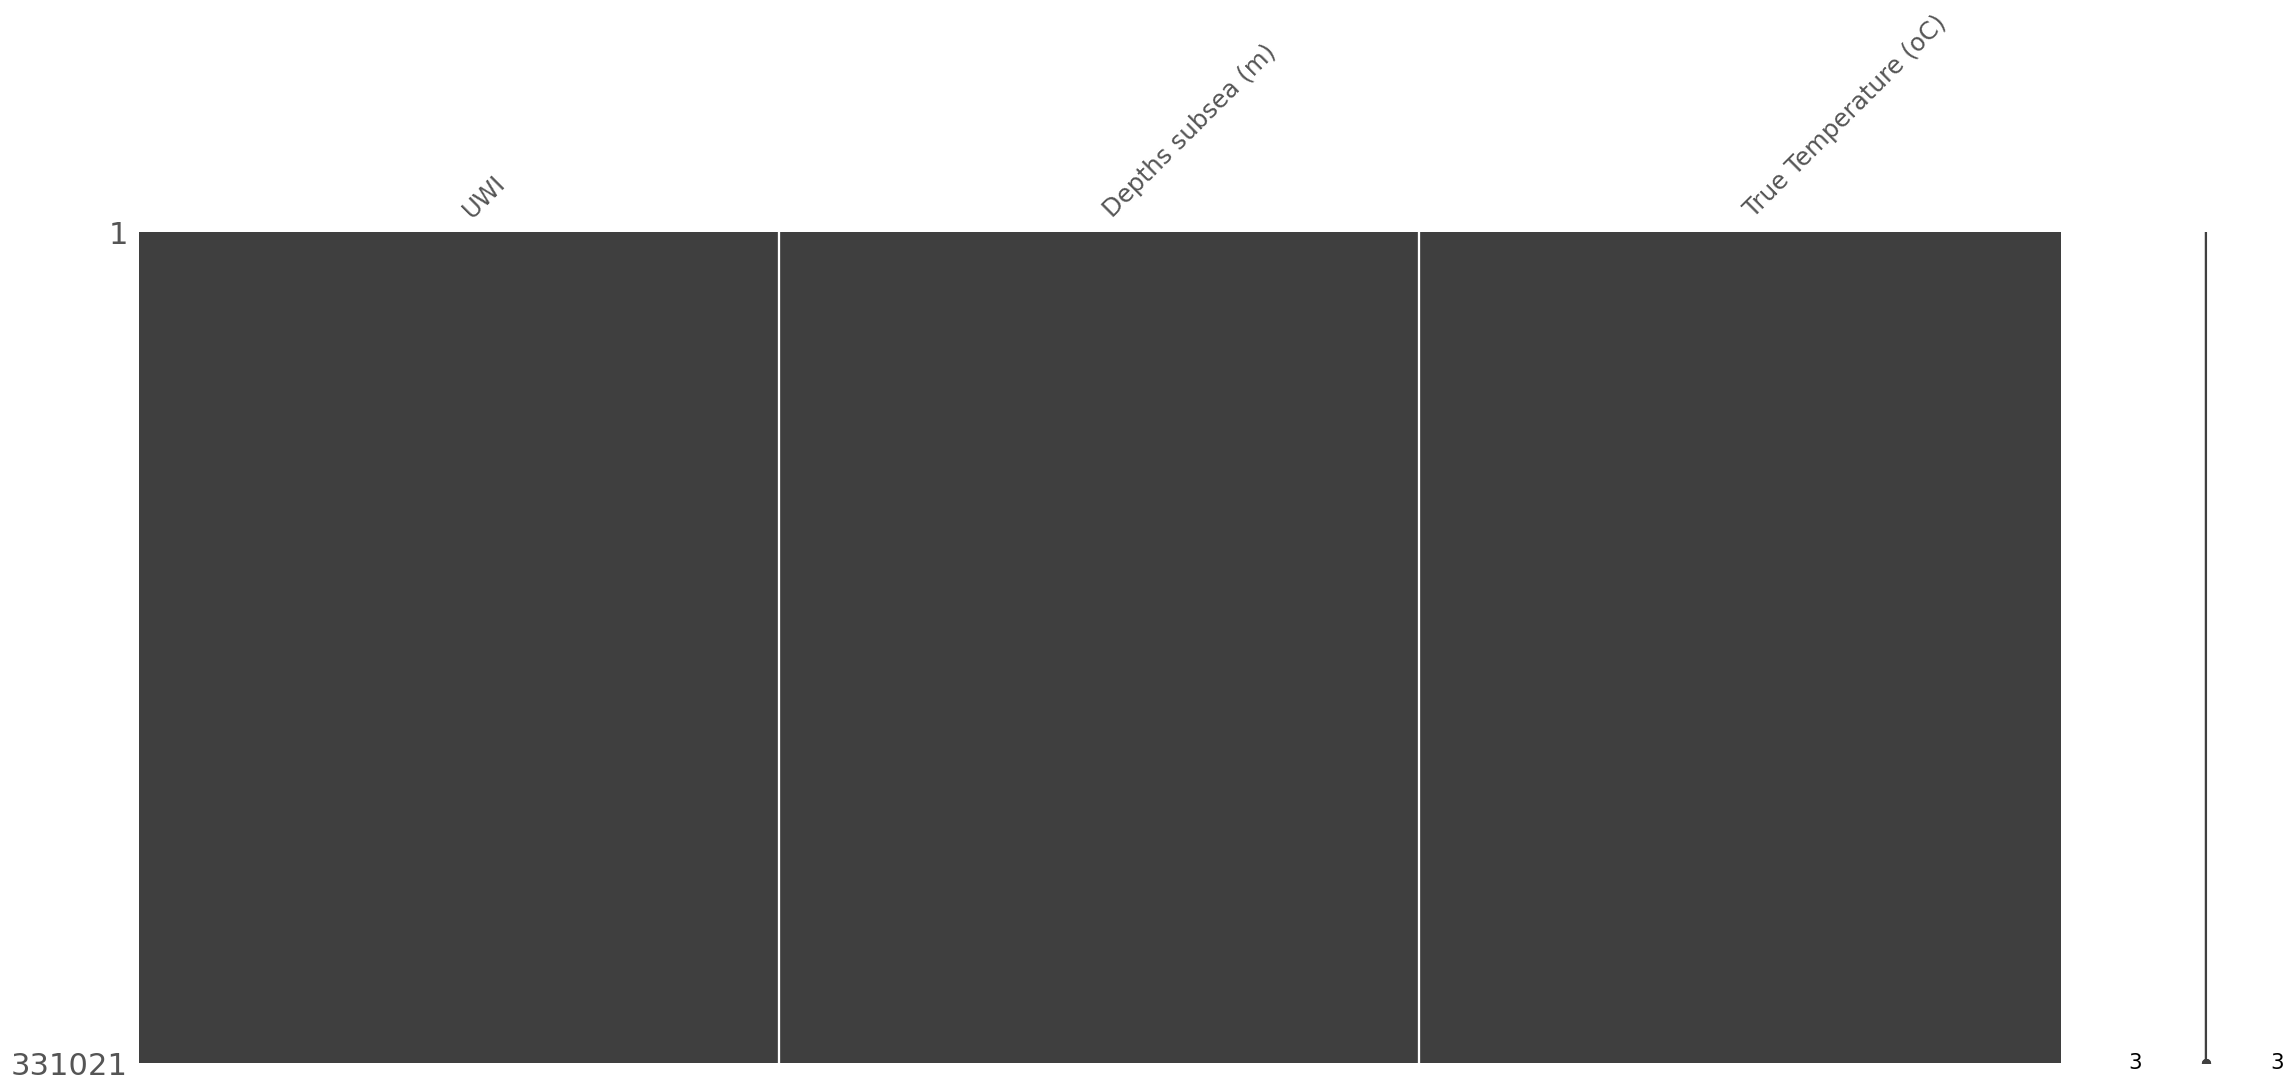

In [ ]:
dvnTrueTemp = pd.read_excel(DVN_PATH + dvnFiles[0])
print(dvnTrueTemp.shape, dvnTrueTemp.UWI.nunique())
msno.matrix(dvnTrueTemp)
plt.show()

#### BHT

(512, 12) 512 True True


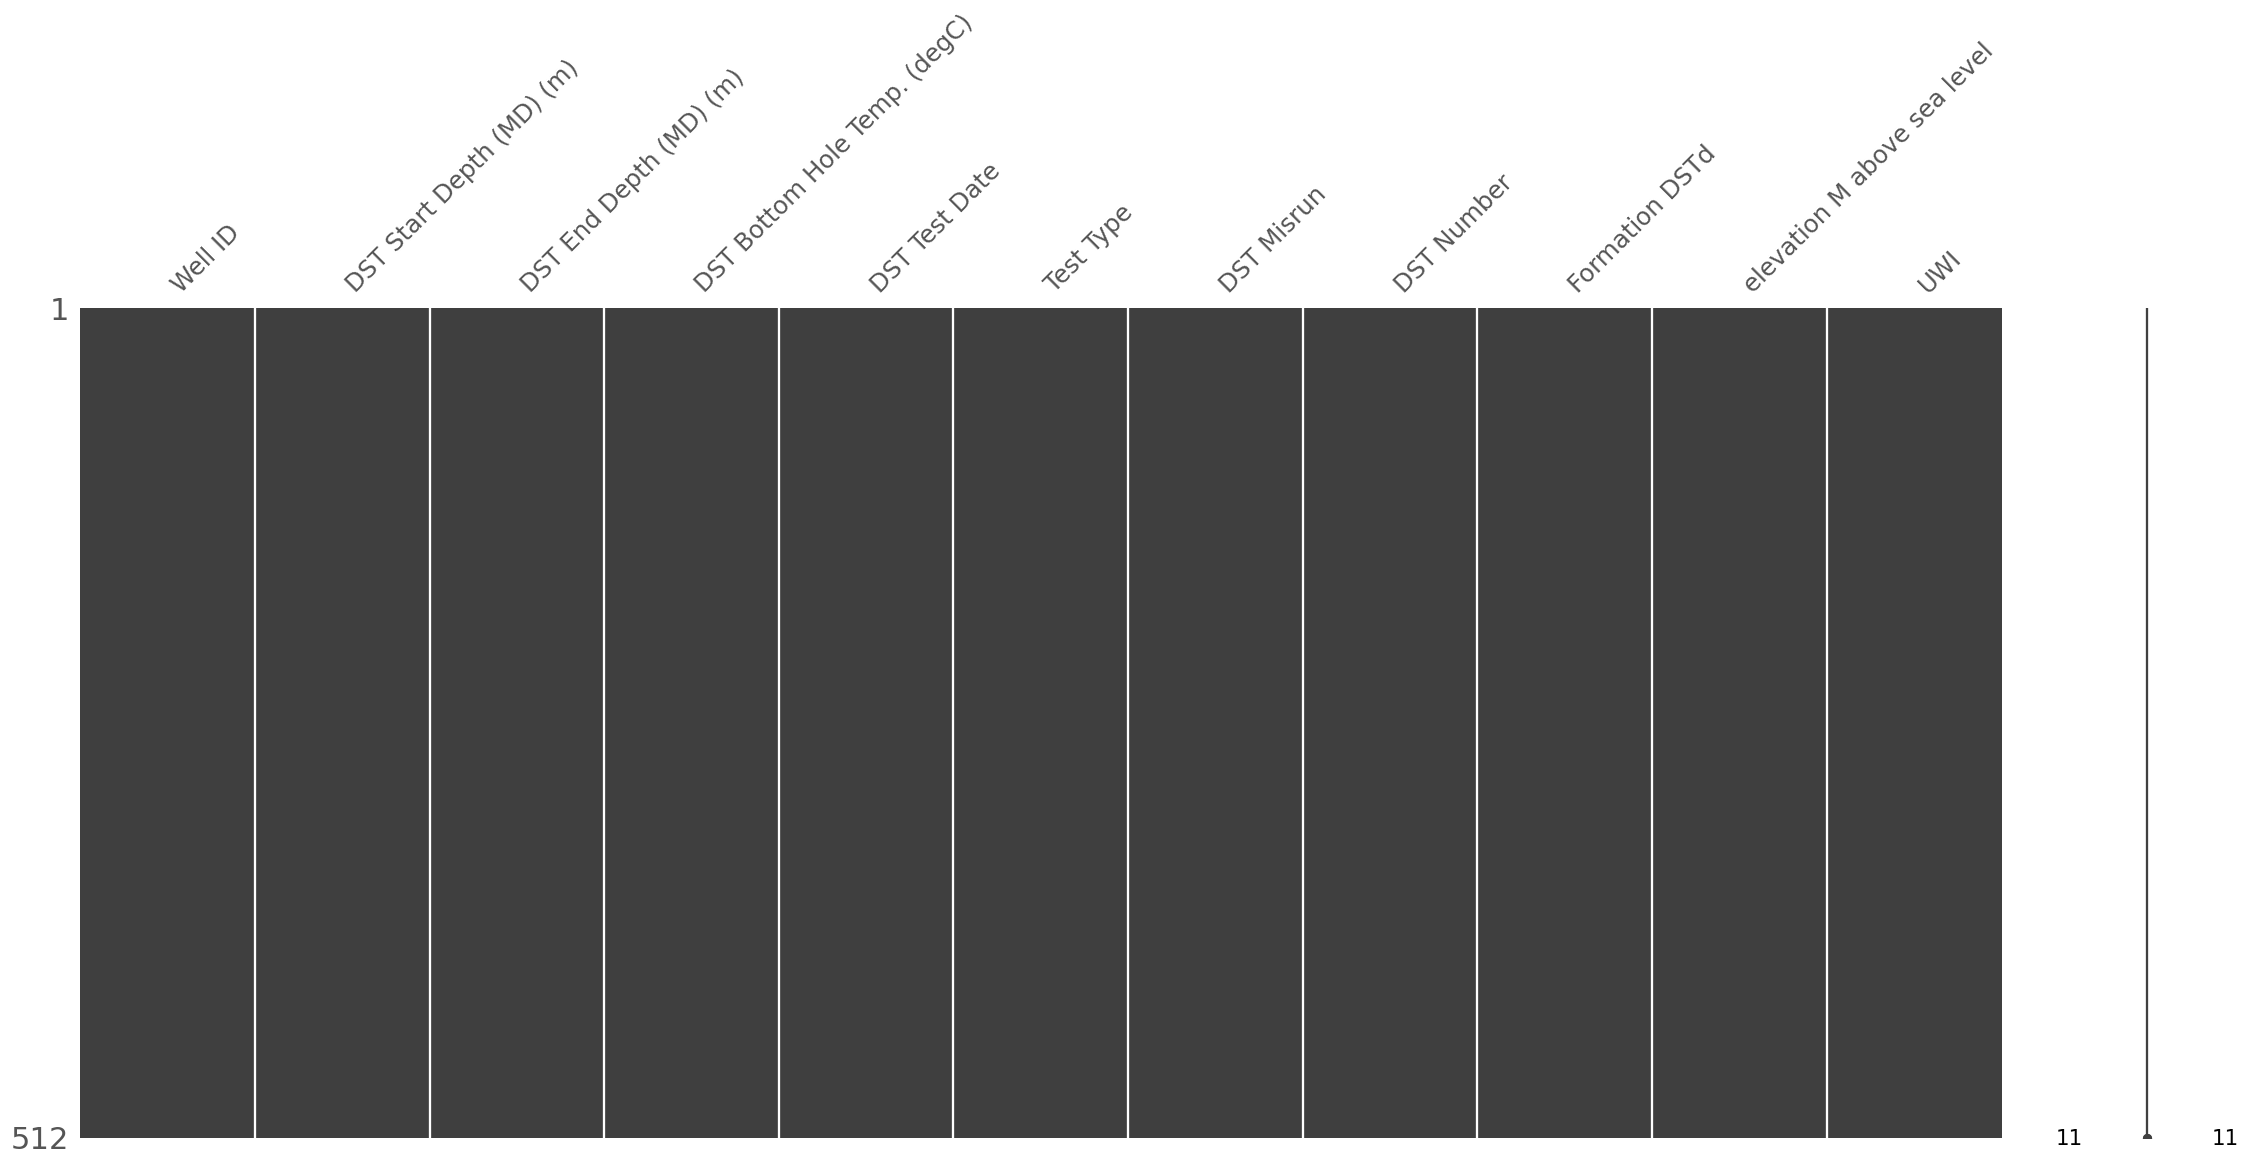

In [ ]:
dvnBHT = pd.read_excel(DVN_PATH + dvnFiles[1])
print(
    dvnBHT.shape,
    dvnBHT.UWI.nunique(),
    all(dvnBHT['Well ID'] == dvnBHT['UWI']),
    set(dvnBHT.UWI).issuperset(
        set(setAssign[setAssign.Play=='DVN'].UWI))
)
dvnBHT = dvnBHT.dropna(how='all', axis=1)
msno.matrix(dvnBHT)
plt.show()

#### Pressure

(512, 38) 512


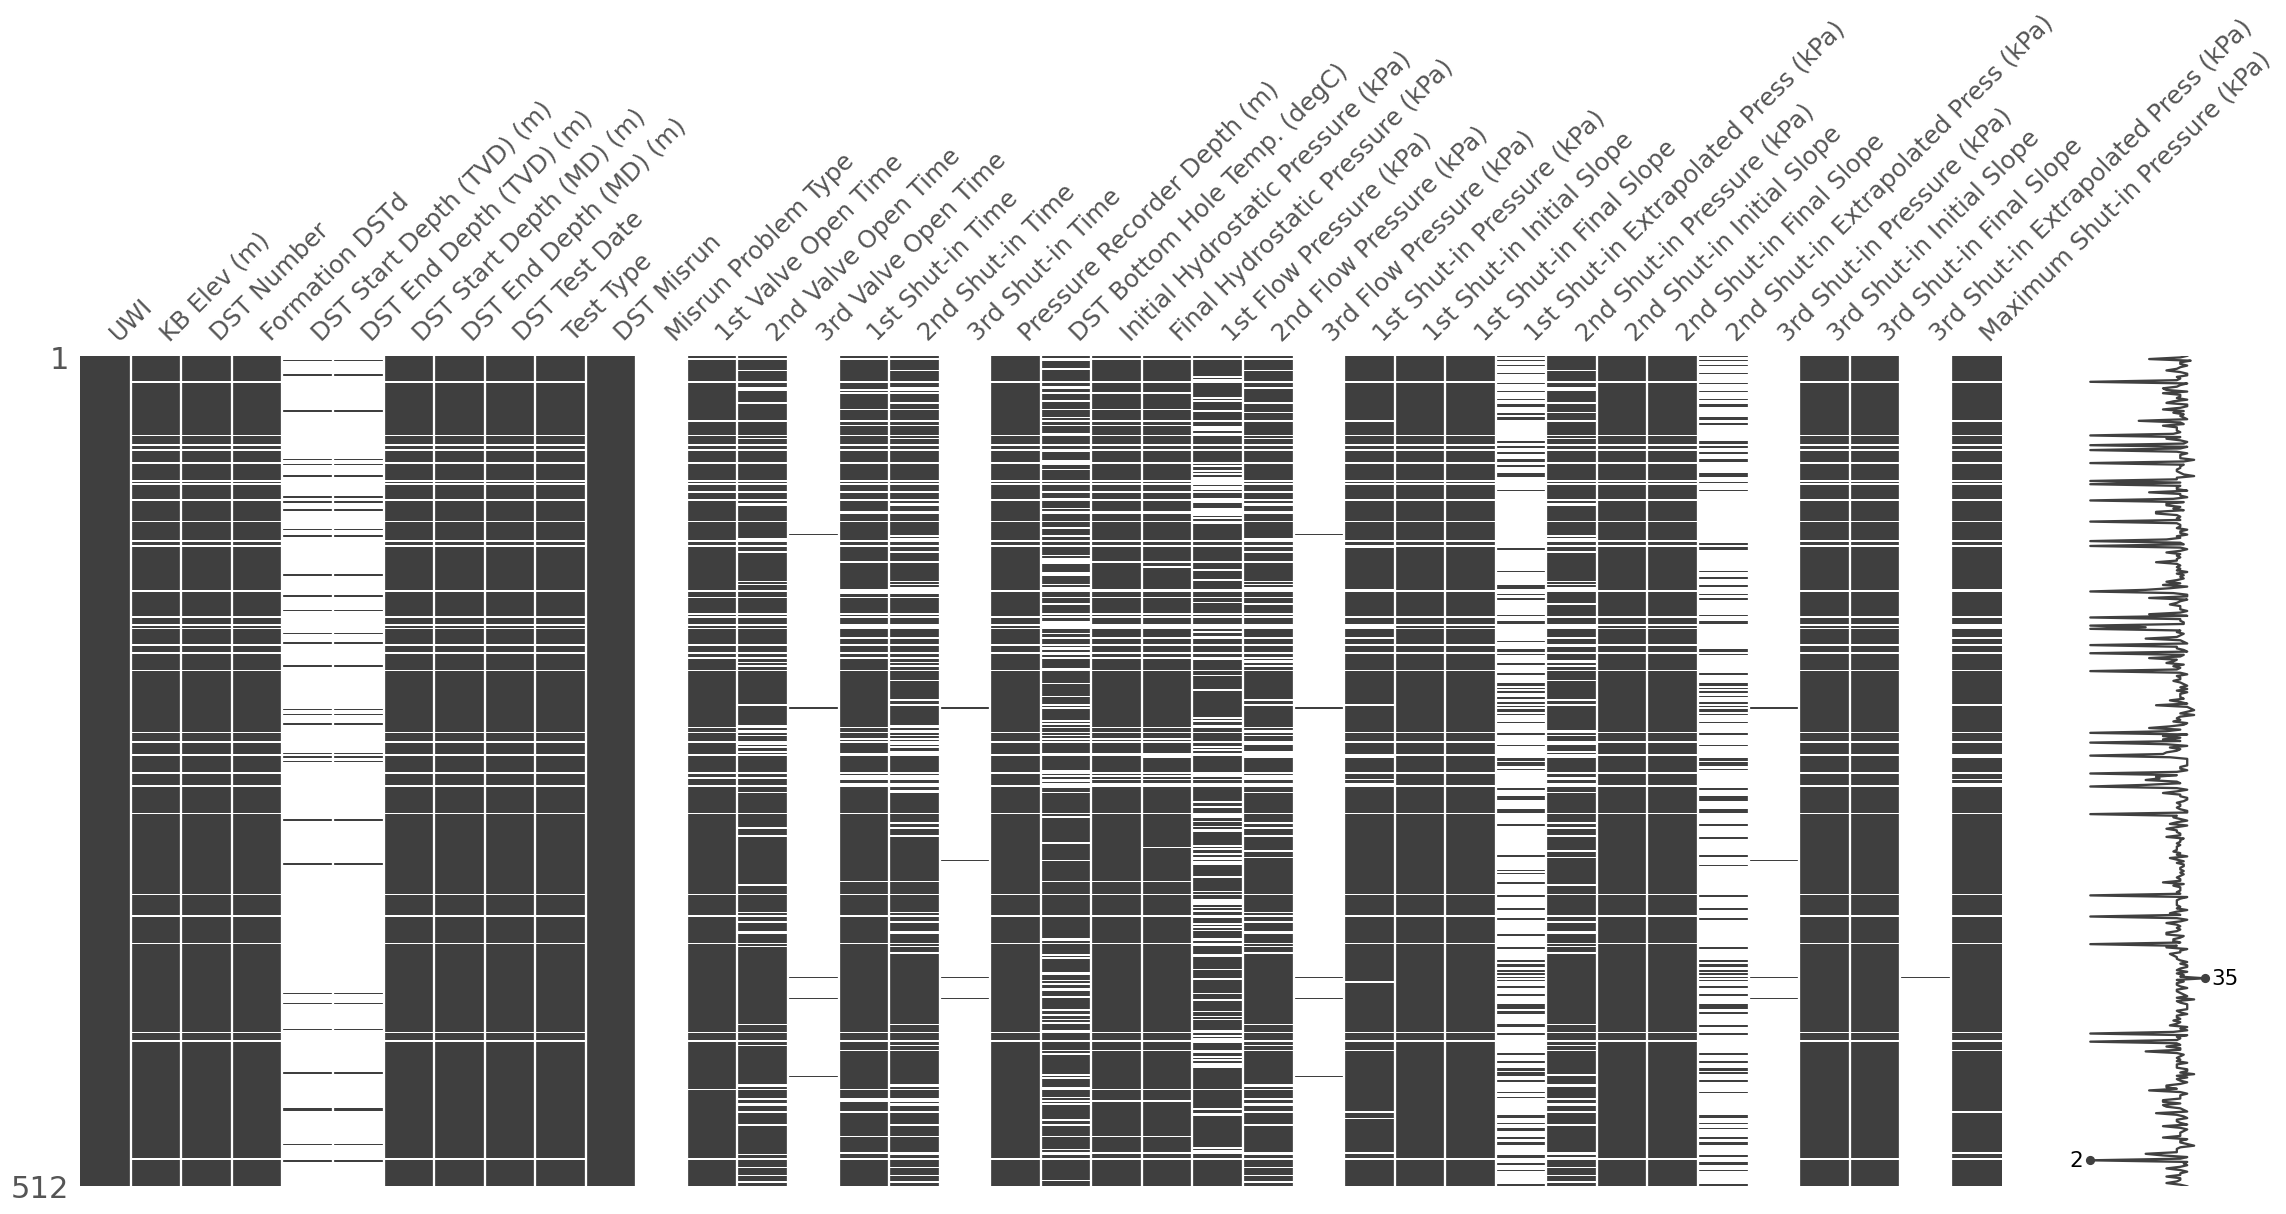

In [ ]:
dvnPres = pd.read_excel(DVN_PATH + dvnFiles[2])
dvnPres = dvnPres.rename(columns={'Well ID': 'UWI'})
print(dvnPres.shape, dvnPres.UWI.nunique())
msno.matrix(dvnPres)
plt.show()

#### Formation Tops

(512, 21) 512


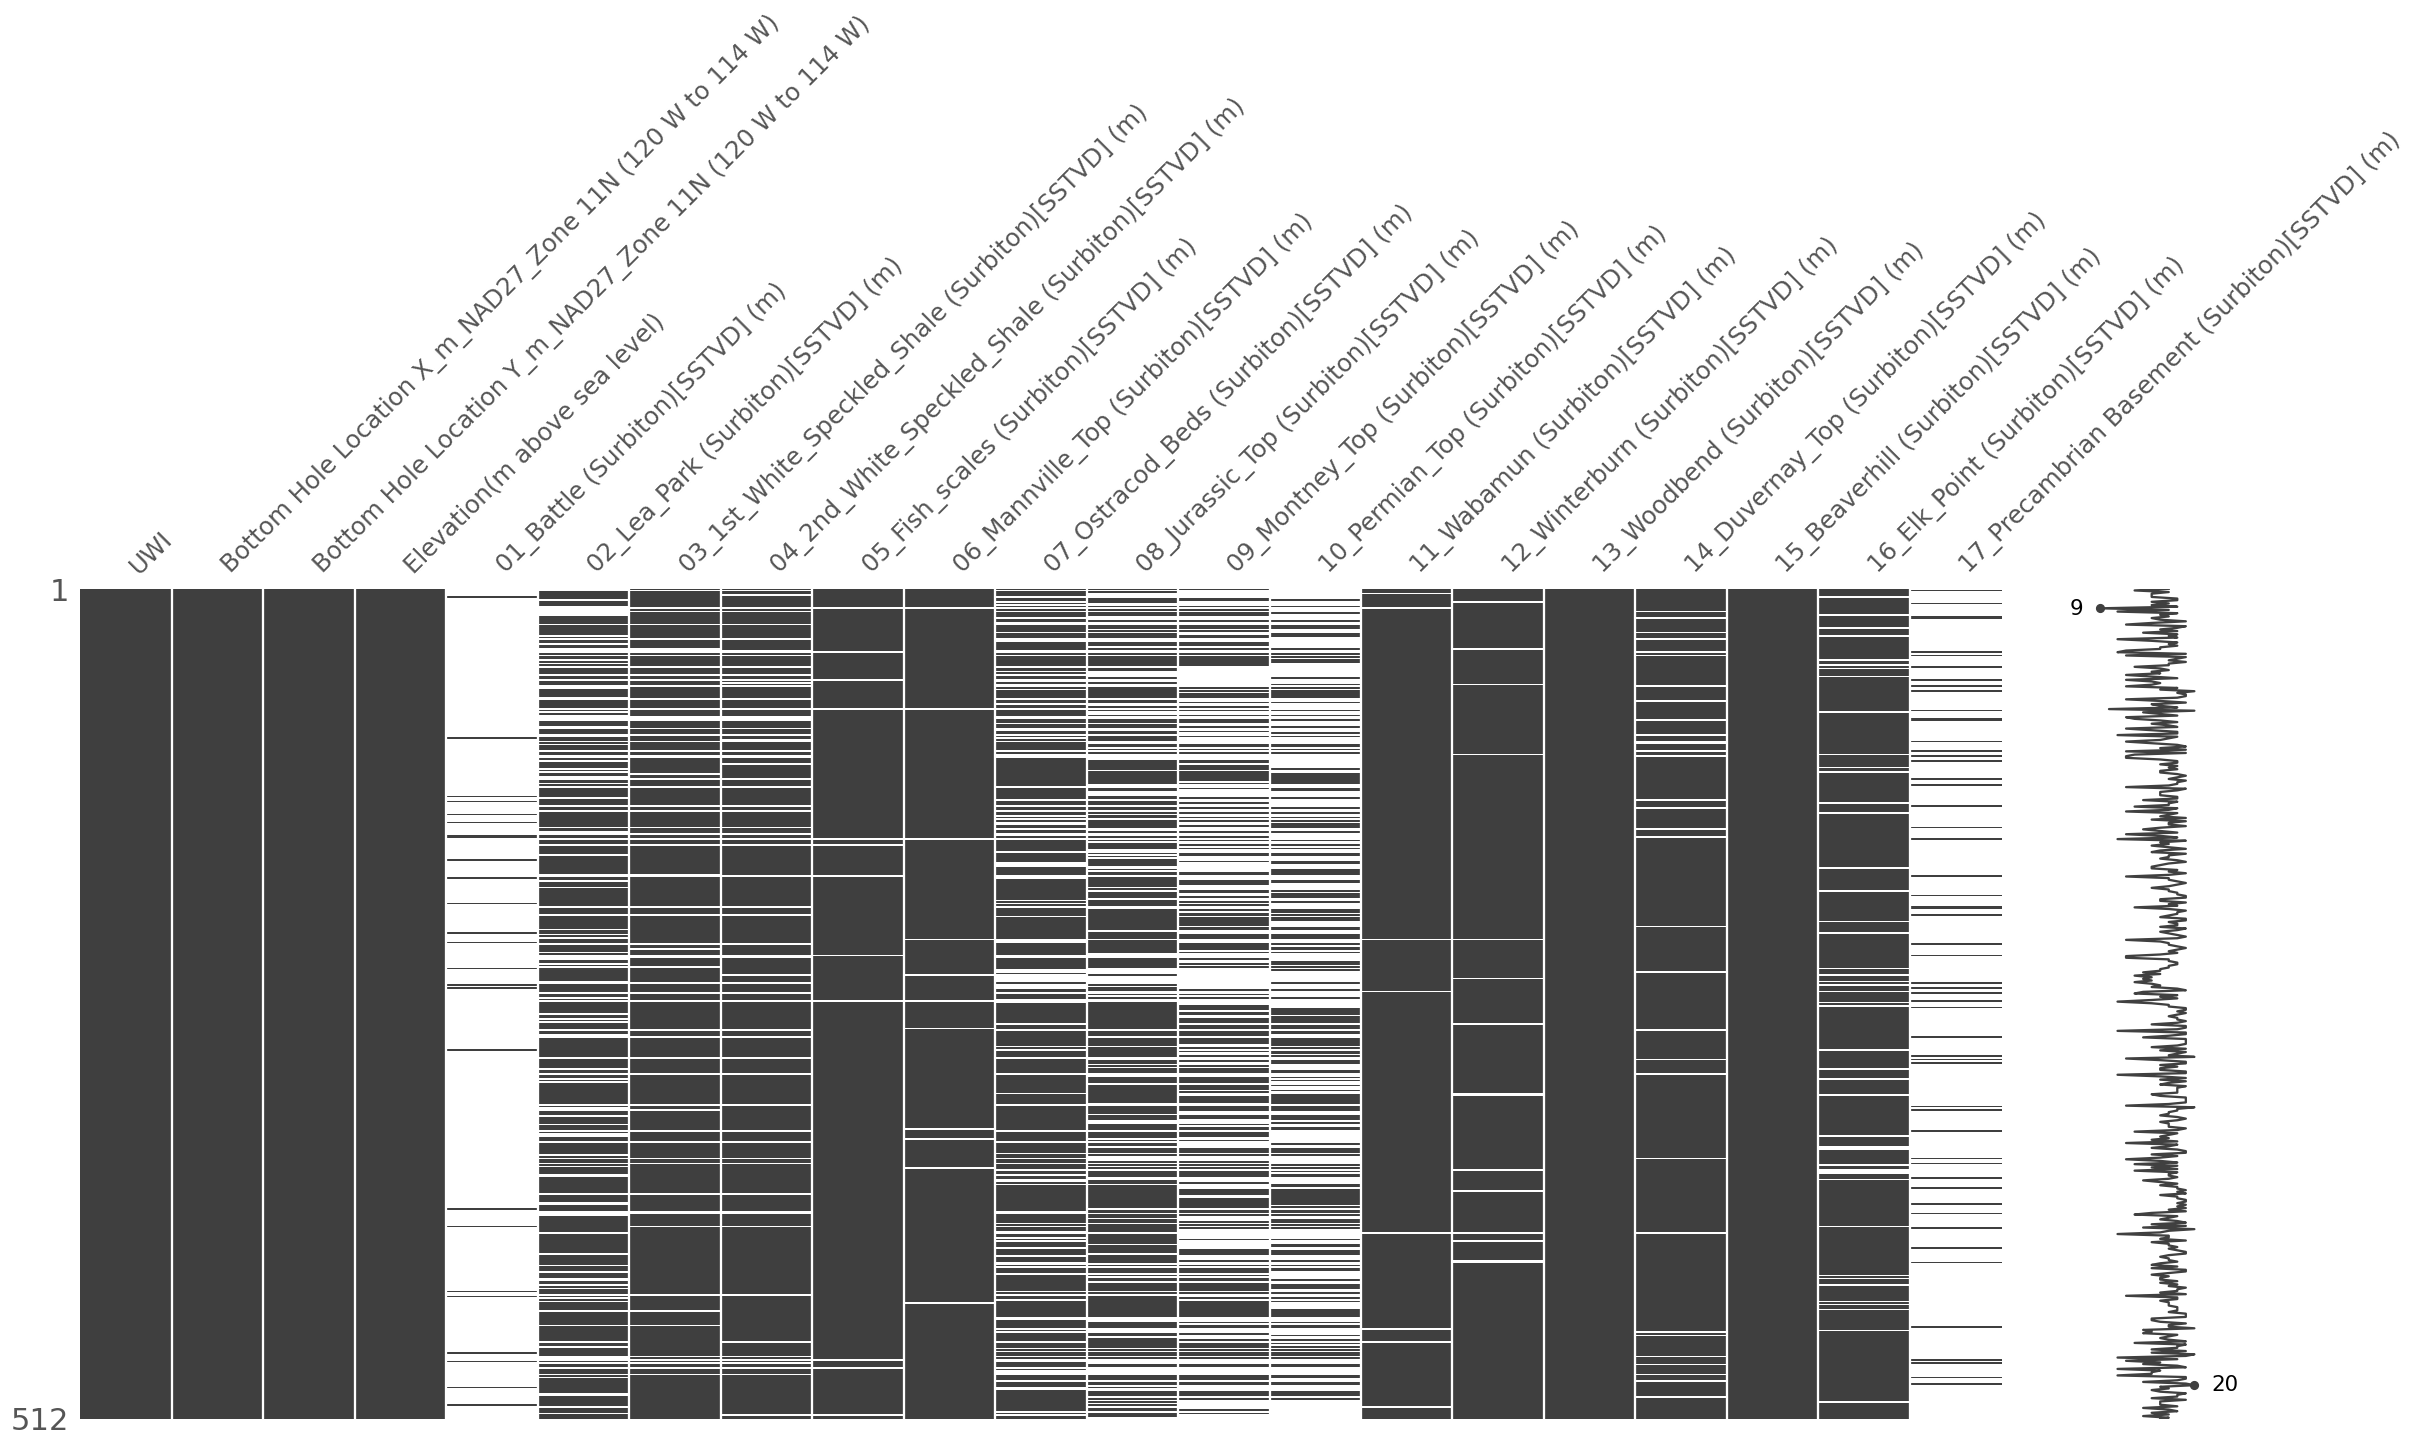

In [ ]:
dvnFT = pd.read_excel(DVN_PATH + dvnFiles[3])
print(dvnFT.shape, dvnFT.UWI.nunique())
msno.matrix(dvnFT)
plt.show()

#### Wellheader

(512, 12) 512


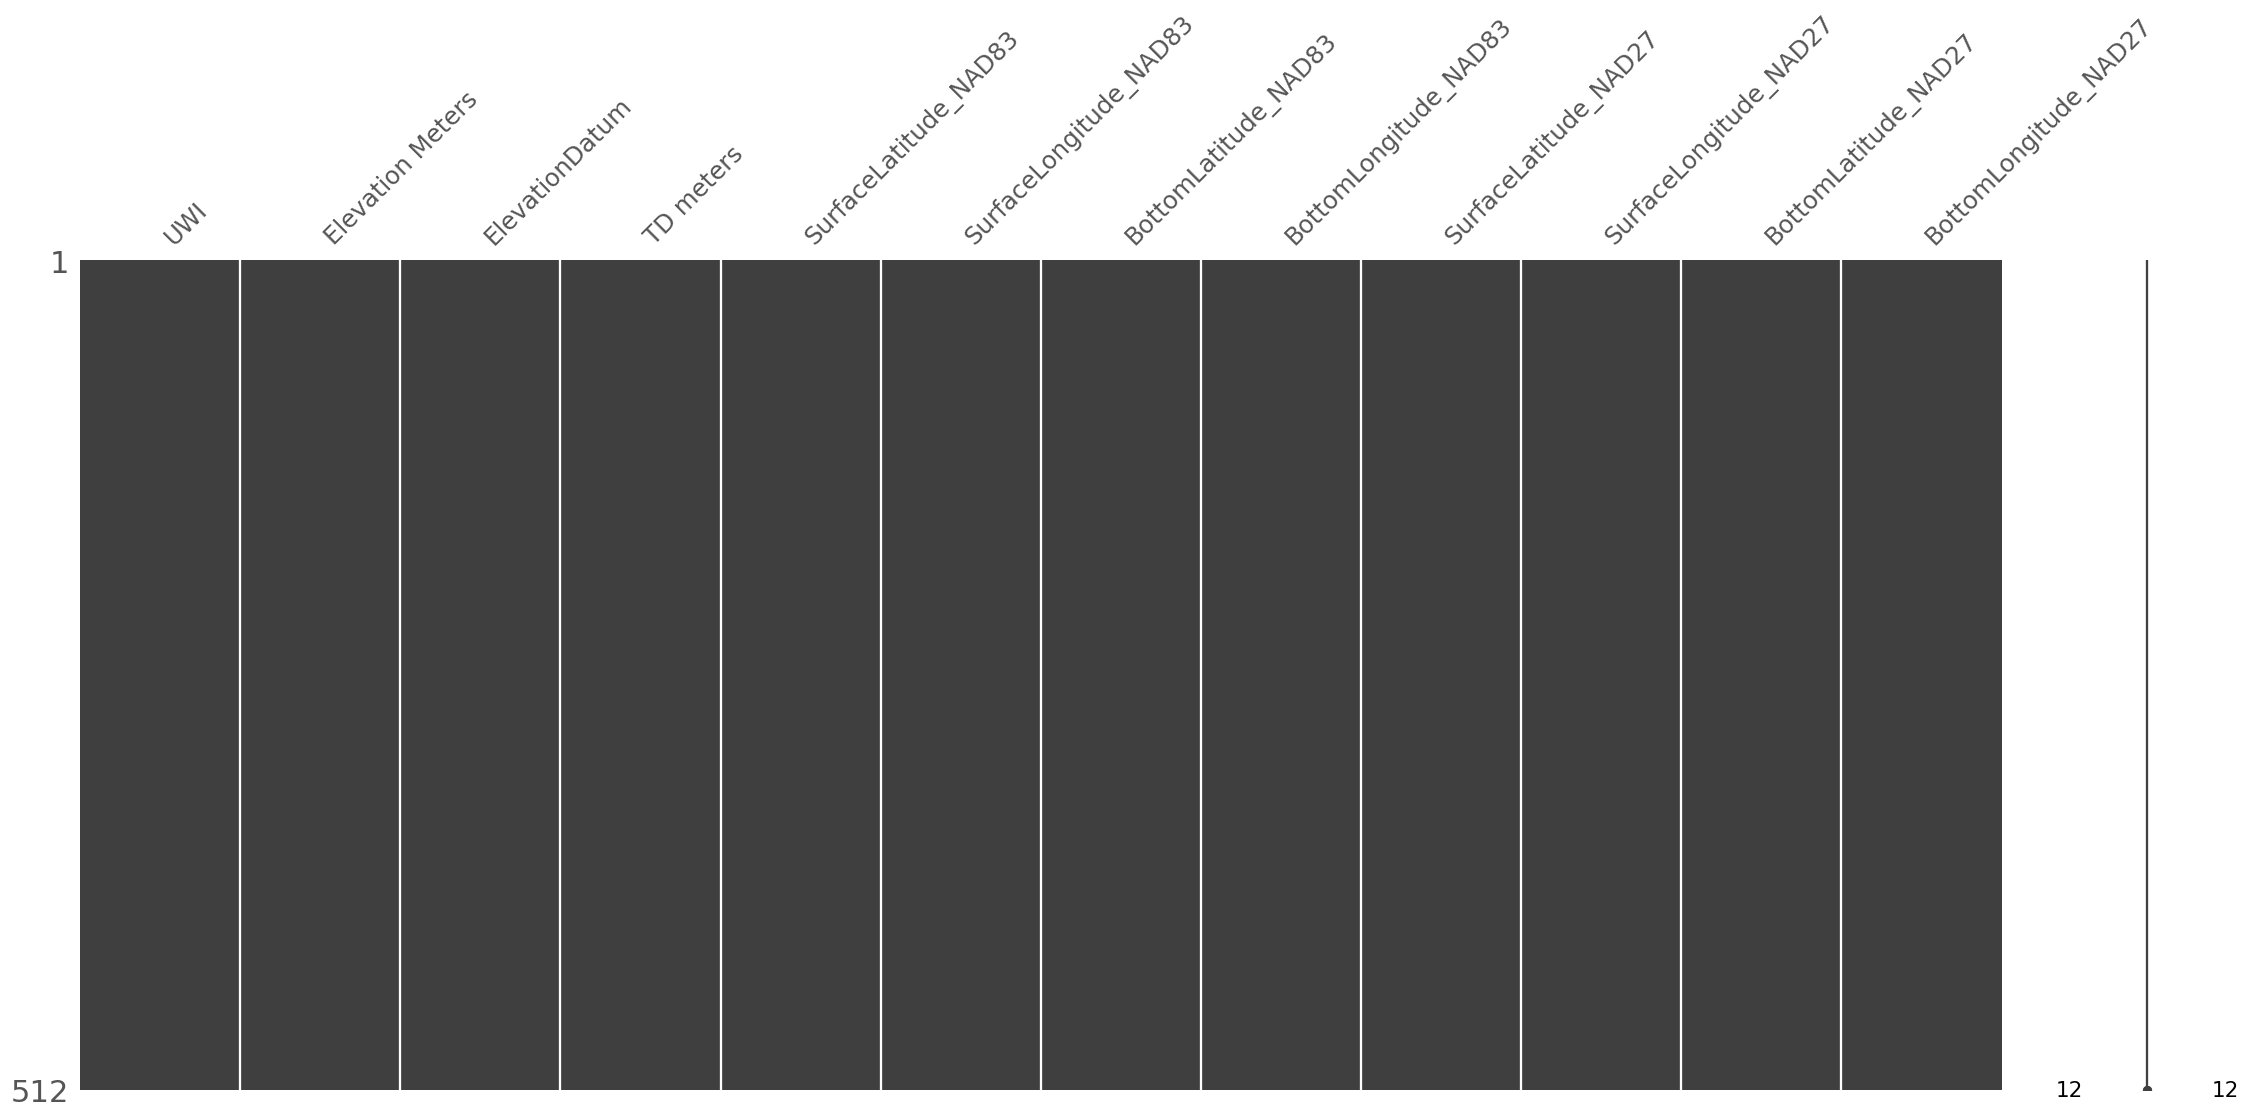

In [ ]:
dvnWH = pd.read_excel(DVN_PATH + dvnFiles[4])
dvnWH.columns = dvnWH.columns.str.strip()
print(dvnWH.shape, dvnWH.UWI.nunique())
msno.matrix(dvnWH)
plt.show()

#### Production

(512, 24) 512


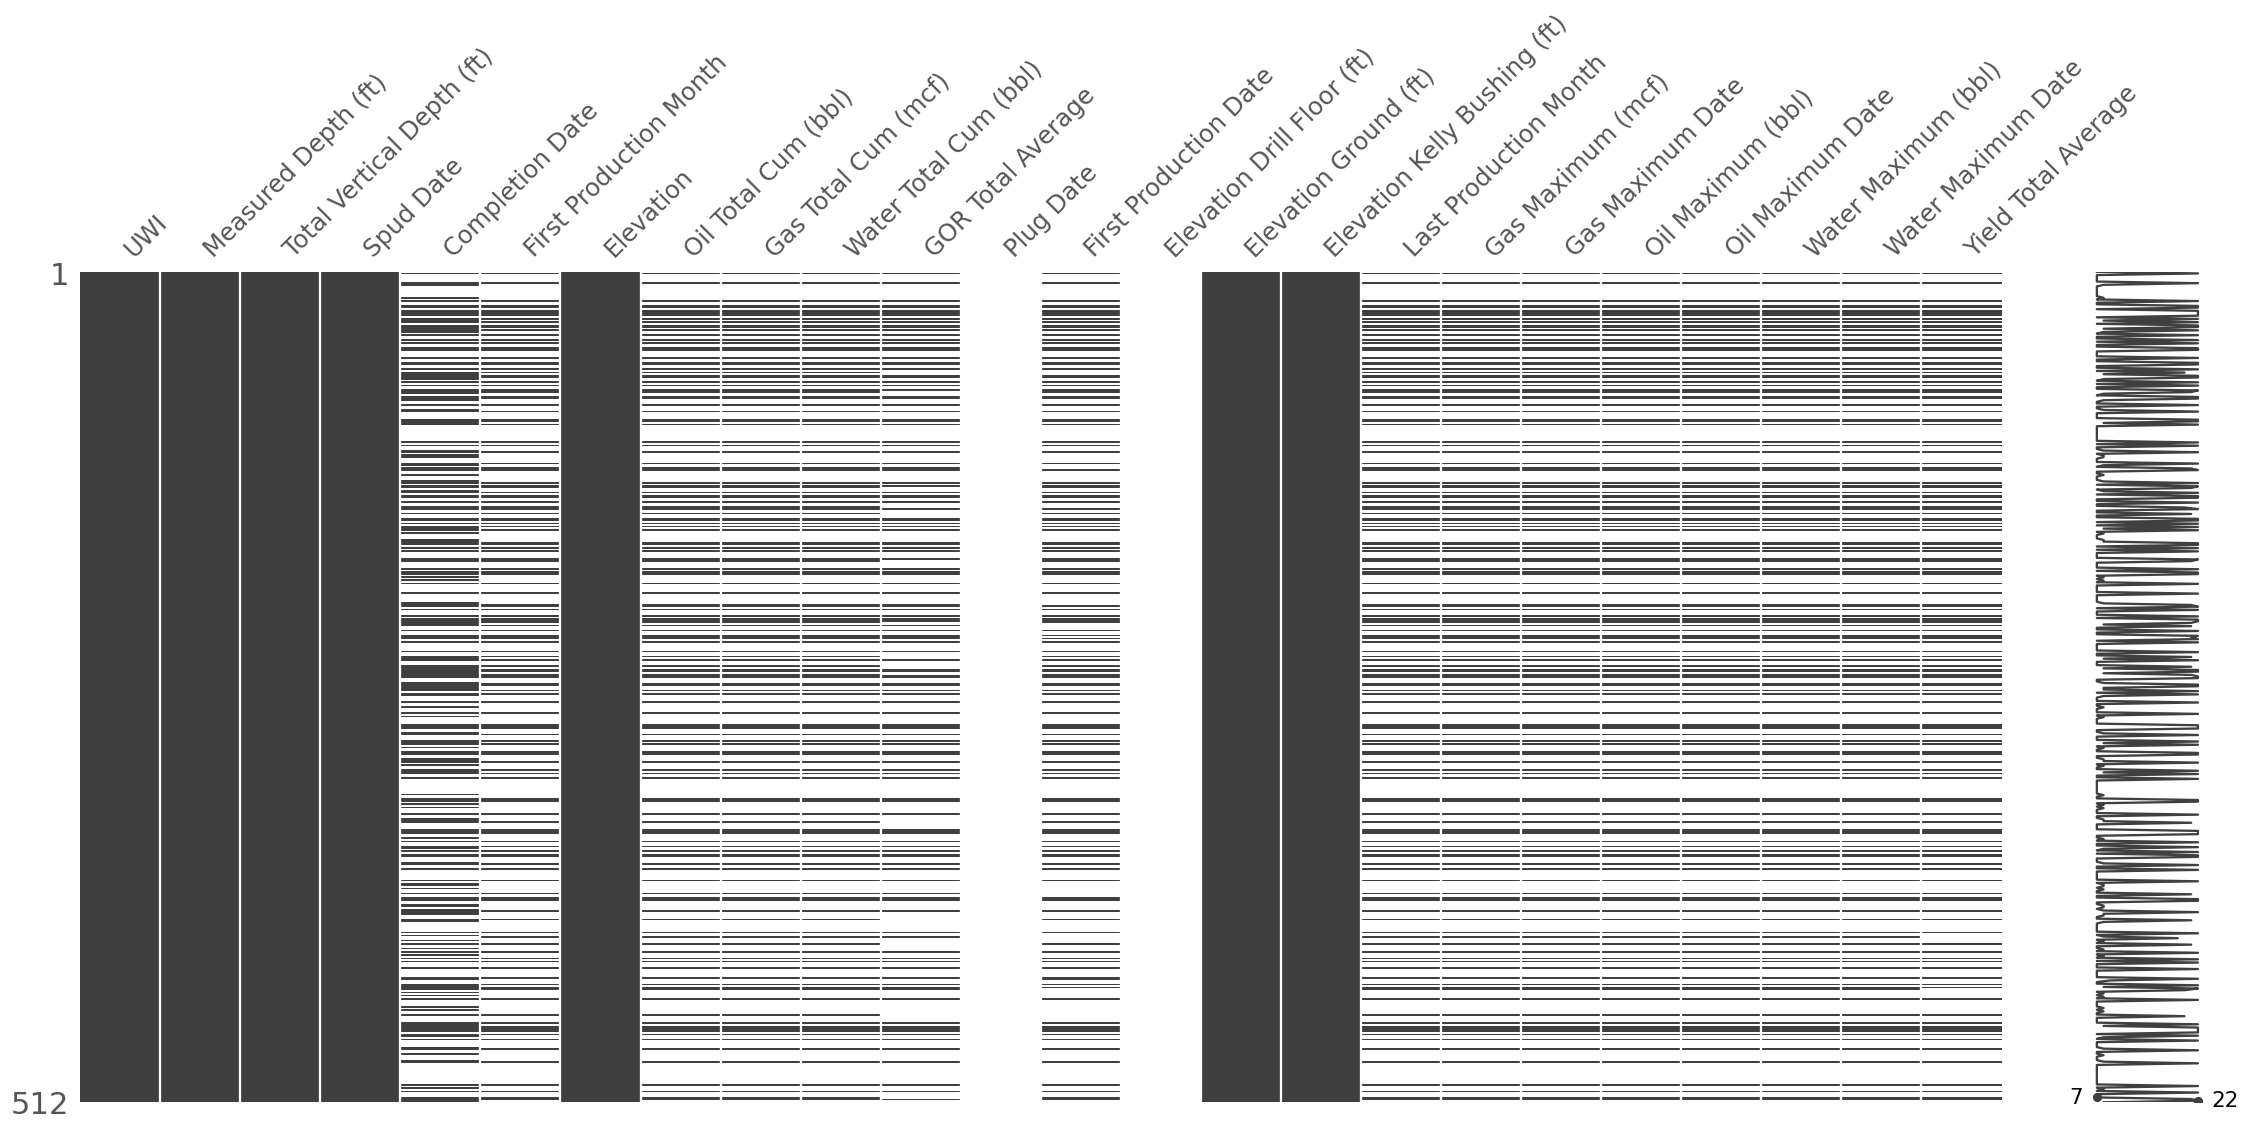

In [ ]:
dvnProd = pd.read_excel(DVN_PATH + dvnFiles[6])
dvnProd.columns = dvnProd.columns.str.strip()
dvnProd = dvnProd.rename(columns={'API': 'UWI'})
dvnProd = dvnProd.dropna(how='all')
print(dvnProd.shape, dvnProd.UWI.nunique())
msno.matrix(dvnProd)
plt.show()

In [ ]:
dvnProd = ft2m(dvnProd, st='(ft)')

#### Combine BHT and TrueTemp + StaticTemp

In [ ]:
dvnBHT['Depths subsea (m)'] = 0.5 * \
    (dvnBHT['DST Start Depth (MD) (m)'] + dvnBHT['DST End Depth (MD) (m)']) - \
    dvnBHT['elevation M above sea level']
dvnBHT = dvnBHT.drop('UWI', axis=1)
dvnBHT = dvnBHT.rename(columns={'Well ID': 'UWI'})

In [ ]:
temp = (dvnTrueTemp
        .append(dvnBHT[['UWI', 'Depths subsea (m)']])
        .sort_values(['UWI', 'Depths subsea (m)']))
temp2 = pd.DataFrame()
for uwi in temp.UWI.unique():
    temp2 = temp2.append((temp[temp.UWI == uwi]
                         .set_index(['Depths subsea (m)'])
                         .interpolate('nearest')
                         .reset_index()))

In [ ]:
dvnCombined = pd.merge(
    dvnBHT,
    temp2.add_suffix('_TrueTemp'),
    left_on=['UWI', 'Depths subsea (m)'],
    right_on=['UWI_TrueTemp', 'Depths subsea (m)_TrueTemp'],
    how='left'
)
dvnCombined = dvnCombined.drop(
    ['UWI_TrueTemp', 'Depths subsea (m)_TrueTemp'], axis=1)
dvnCombined

,UWI,DST Start Depth (MD) (m),DST End Depth (MD) (m),DST Bottom Hole Temp. (degC),DST Test Date,Test Type,DST Misrun,DST Number,Formation DSTd,elevation M above sea level,Depths subsea (m),True Temperature (oC)_TrueTemp
0,100010107020W500,1410.6,1423.4,48.33,26025,DST,N,2,TRmontney,701.0,716.00,60.97
1,100010608109W500,1686.0,1694.0,34.26,33647,DST,N,1,Dmuskeg,645.6,1044.40,63.98
2,100010904012W500,3698.0,3718.0,104.40,30798,LRT,N,1,Melkton,1283.8,2424.20,NaN
3,100011206021W400,822.0,825.0,29.00,29543,DST,N,4,Dwintrbrn,651.6,171.90,39.07
4,100011506915W500,1801.0,1818.0,64.00,30760,DST,N,4,Dwabamun,873.1,936.40,69.47
...,...,...,...,...,...,...,...,...,...,...,...,...
507,102101403324W400,2403.0,2417.0,72.50,32200,DST,N,1,Dbvrhl_lk,896.5,1513.50,NaN
508,102102106218W500,3031.2,3079.7,83.89,27873,DST,N,1,Dswan_hl,878.7,2176.75,NaN
509,102112204416W500,2961.0,4697.0,89.20,32046,DST,N,1,Dbvrhl_lk,1175.1,2653.90,NaN
510,102142004709W500,2290.0,2305.0,68.80,28876,DST,N,1,Jrock_ck,956.3,1341.20,81.48


In [ ]:
temp = pd.merge(dvnBHT[['UWI',
                        'DST Start Depth (MD) (m)',
                        'DST End Depth (MD) (m)',
                        'DST Bottom Hole Temp. (degC)']],
                dataStatic, on='UWI')
temp['Depth Diff.'] = (0.5*(temp['DST Start Depth (MD) (m)'] +
                            temp['DST End Depth (MD) (m)']) -
                       temp['Depth (m)']).round(2)
temp = pd.merge(temp, dvnProd[['UWI',
                               'Measured Depth (m)',
                               'Total Vertical Depth (m)']], on='UWI')
temp

,UWI,DST Start Depth (MD) (m),DST End Depth (MD) (m),DST Bottom Hole Temp. (degC),Depth (m),Temp (degC),Field,Depth Diff.,Measured Depth (m),Total Vertical Depth (m)
0,100022706319W500,1799.2,1812.6,76.67,3074.517600,117.611111,Duvernay,-1268.62,3082.1376,3082.1376
1,100022806419W500,1399.3,1424.9,48.89,2945.282400,111.055556,Duvernay,-1533.18,2994.9648,2994.9648
2,100050506418W500,1449.3,1460.0,50.00,2529.840000,92.777778,Duvernay,-1075.19,3033.9792,3033.9792
3,100060905918W500,2318.0,2331.7,77.78,1043.940000,95.000000,Duvernay,1280.91,3511.9056,3511.9056
4,100061305216W500,3083.0,3107.0,84.00,3676.999910,117.000000,Duvernay,-582.00,3677.1072,3677.1072
5,100061706804W600,2475.0,2496.6,77.78,3307.080000,104.444444,Duvernay,-821.28,3846.8808,3846.8808
6,100071406220W500,1699.0,1708.1,54.44,2930.956800,90.555556,Duvernay,-1227.41,3315.9192,3315.9192
7,100081504804W500,1578.9,1597.8,54.44,NaN,60.000000,Duvernay,NaN,2560.0152,2560.0152
8,100101606419W500,1454.5,1460.0,50.00,1371.600000,76.666667,Duvernay,85.65,3018.1296,3018.1296
9,100101706419W500,1481.3,1502.7,48.89,1219.200000,61.666667,Duvernay,272.80,3062.9352,3062.9352


In [ ]:
dvnCombined = pd.merge(
    dvnCombined, 
    dataStatic.add_suffix('_ST'), 
    left_on=['UWI'], 
    right_on=['UWI_ST'], 
    how='left'
)
dvnCombined = dvnCombined.drop(['UWI_ST', 'Field_ST'], axis=1)

#### Combine the rest

In [ ]:
for df, suffix in zip([dvnPres, dvnProd, dvnWH, dvnFT, setAssign], 
                      ['_Pres', '_Prod', '_WH', '_FT', '_']):
    dvnCombined = pd.merge(
        dvnCombined,
        df.add_suffix(suffix),
        left_on=['UWI'],
        right_on=['UWI'+suffix],
        how='left',
        validate='1:1'
    )
    dvnCombined = dvnCombined.drop(['UWI'+suffix], axis=1)
dvnCombined

,UWI,DST Start Depth (MD) (m),DST End Depth (MD) (m),DST Bottom Hole Temp. (degC),DST Test Date,Test Type,DST Misrun,DST Number,Formation DSTd,elevation M above sea level,Depths subsea (m),True Temperature (oC)_TrueTemp,Depth (m)_ST,Temp (degC)_ST,KB Elev (m)_Pres,DST Number_Pres,Formation DSTd_Pres,DST Start Depth (TVD) (m)_Pres,DST End Depth (TVD) (m)_Pres,DST Start Depth (MD) (m)_Pres,DST End Depth (MD) (m)_Pres,DST Test Date_Pres,Test Type_Pres,DST Misrun_Pres,Misrun Problem Type_Pres,1st Valve Open Time_Pres,2nd Valve Open Time_Pres,3rd Valve Open Time_Pres,1st Shut-in Time_Pres,2nd Shut-in Time_Pres,3rd Shut-in Time_Pres,Pressure Recorder Depth (m)_Pres,DST Bottom Hole Temp. (degC)_Pres,Initial Hydrostatic Pressure (kPa)_Pres,Final Hydrostatic Pressure (kPa)_Pres,1st Flow Pressure (kPa)_Pres,2nd Flow Pressure (kPa)_Pres,3rd Flow Pressure (kPa)_Pres,1st Shut-in Pressure (kPa)_Pres,1st Shut-in Initial Slope_Pres,1st Shut-in Final Slope_Pres,1st Shut-in Extrapolated Press (kPa)_Pres,2nd Shut-in Pressure (kPa)_Pres,2nd Shut-in Initial Slope_Pres,2nd Shut-in Final Slope_Pres,2nd Shut-in Extrapolated Press (kPa)_Pres,3rd Shut-in Pressure (kPa)_Pres,3rd Shut-in Initial Slope_Pres,3rd Shut-in Final Slope_Pres,3rd Shut-in Extrapolated Press (kPa)_Pres,...,Oil Total Cum (bbl)_Prod,Gas Total Cum (mcf)_Prod,Water Total Cum (bbl)_Prod,GOR Total Average_Prod,Plug Date_Prod,First Production Date_Prod,Elevation Drill Floor (m)_Prod,Elevation Ground (m)_Prod,Elevation Kelly Bushing (m)_Prod,Last Production Month_Prod,Gas Maximum (mcf)_Prod,Gas Maximum Date_Prod,Oil Maximum (bbl)_Prod,Oil Maximum Date_Prod,Water Maximum (bbl)_Prod,Water Maximum Date_Prod,Yield Total Average_Prod,Elevation Meters_WH,ElevationDatum_WH,TD meters_WH,SurfaceLatitude_NAD83_WH,SurfaceLongitude_NAD83_WH,BottomLatitude_NAD83_WH,BottomLongitude_NAD83_WH,SurfaceLatitude_NAD27_WH,SurfaceLongitude_NAD27_WH,BottomLatitude_NAD27_WH,BottomLongitude_NAD27_WH,Bottom Hole Location X_m_NAD27_Zone 11N (120 W to 114 W)_FT,Bottom Hole Location Y_m_NAD27_Zone 11N (120 W to 114 W)_FT,Elevation(m above sea level)_FT,01_Battle (Surbiton)[SSTVD] (m)_FT,02_Lea_Park (Surbiton)[SSTVD] (m)_FT,03_1st_White_Speckled_Shale (Surbiton)[SSTVD] (m)_FT,04_2nd_White_Speckled_Shale (Surbiton)[SSTVD] (m)_FT,05_Fish_scales (Surbiton)[SSTVD] (m)_FT,06_Mannville_Top (Surbiton)[SSTVD] (m)_FT,07_Ostracod_Beds (Surbiton)[SSTVD] (m)_FT,08_Jurassic_Top (Surbiton)[SSTVD] (m)_FT,09_Montney_Top (Surbiton)[SSTVD] (m)_FT,10_Permian_Top (Surbiton)[SSTVD] (m)_FT,11_Wabamun (Surbiton)[SSTVD] (m)_FT,12_Winterburn (Surbiton)[SSTVD] (m)_FT,13_Woodbend (Surbiton)[SSTVD] (m)_FT,14_Duvernay_Top (Surbiton)[SSTVD] (m)_FT,15_Beaverhill (Surbiton)[SSTVD] (m)_FT,16_Elk_Point (Surbiton)[SSTVD] (m)_FT,17_Precambrian Basement (Surbiton)[SSTVD] (m)_FT,Set_,Play_
0,100010107020W500,1410.6,1423.4,48.33,26025,DST,N,2,TRmontney,701.0,716.00,60.97,NaN,NaN,701.0,2.0,TRmontney,NaN,NaN,1410.6,1423.4,26025.0,DST,N,NaN,3.0,60.0,NaN,60.0,90.0,NaN,1412.44,48.33,15899.31,15899.31,648.11,2392.48,NaN,12858.73,88.0,10.0,12920.78,12403.67,86.0,15.0,12920.78,NaN,0.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaT,NaN,697.0776,701.0400,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,701.093481,KB,2767.67480,55.027981,-116.903553,55.027981,-116.903553,55.027981,-116.903553,55.027981,-116.903553,506245.60,6097691.89,701.0,NaN,NaN,189.50,-3.4,-214.00,-307.0,-607.70,-627.3,-713.3,NaN,-1271.1,-1508.8,-1605.1,-1900.50,-1937.30,-2044.30,NaN,Training,DVN
1,100010608109W500,1686.0,1694.0,34.26,33647,DST,N,1,Dmuskeg,645.6,1044.40,63.98,NaN,NaN,645.6,1.0,Dmuskeg,NaN,NaN,1686.0,1694.0,33647.0,DST,N,NaN,6.0,63.0,NaN,59.0,114.0,NaN,1688.20,34.26,18922.00,18137.00,794.00,1564.00,NaN,10782.00,88.0,8.0,NaN,9569.00,88.0,10.0,NaN,NaN,0.0,0.0,NaN,...,3422.286,2.722761e+03,390.597,795.597,NaN,1992-05-22,NaN,640.9944,645.8712,1992-08-01,1084.160,1992-07-01,1639.125,1992-05-01,351.600,1992-05-01,1256.918,645.600000,KB,1745.00000,55.987511,-115.390554,55.987511,-115.390554,55.987511,-115.390554,55

In [ ]:
dvnCombined['target'] = dvnCombined['Temp (degC)_ST'].fillna(
    dvnCombined['True Temperature (oC)_TrueTemp'])
dvnCombined = dvnCombined.drop(
    ['Temp (degC)_ST', 'True Temperature (oC)_TrueTemp'], axis=1)

In [ ]:
dvnCombined[dvnCombined.Set_.isna()]

,UWI,DST Start Depth (MD) (m),DST End Depth (MD) (m),DST Bottom Hole Temp. (degC),DST Test Date,Test Type,DST Misrun,DST Number,Formation DSTd,elevation M above sea level,Depths subsea (m),Depth (m)_ST,KB Elev (m)_Pres,DST Number_Pres,Formation DSTd_Pres,DST Start Depth (TVD) (m)_Pres,DST End Depth (TVD) (m)_Pres,DST Start Depth (MD) (m)_Pres,DST End Depth (MD) (m)_Pres,DST Test Date_Pres,Test Type_Pres,DST Misrun_Pres,Misrun Problem Type_Pres,1st Valve Open Time_Pres,2nd Valve Open Time_Pres,3rd Valve Open Time_Pres,1st Shut-in Time_Pres,2nd Shut-in Time_Pres,3rd Shut-in Time_Pres,Pressure Recorder Depth (m)_Pres,DST Bottom Hole Temp. (degC)_Pres,Initial Hydrostatic Pressure (kPa)_Pres,Final Hydrostatic Pressure (kPa)_Pres,1st Flow Pressure (kPa)_Pres,2nd Flow Pressure (kPa)_Pres,3rd Flow Pressure (kPa)_Pres,1st Shut-in Pressure (kPa)_Pres,1st Shut-in Initial Slope_Pres,1st Shut-in Final Slope_Pres,1st Shut-in Extrapolated Press (kPa)_Pres,2nd Shut-in Pressure (kPa)_Pres,2nd Shut-in Initial Slope_Pres,2nd Shut-in Final Slope_Pres,2nd Shut-in Extrapolated Press (kPa)_Pres,3rd Shut-in Pressure (kPa)_Pres,3rd Shut-in Initial Slope_Pres,3rd Shut-in Final Slope_Pres,3rd Shut-in Extrapolated Press (kPa)_Pres,Maximum Shut-in Pressure (kPa)_Pres,Measured Depth (m)_Prod,...,Gas Total Cum (mcf)_Prod,Water Total Cum (bbl)_Prod,GOR Total Average_Prod,Plug Date_Prod,First Production Date_Prod,Elevation Drill Floor (m)_Prod,Elevation Ground (m)_Prod,Elevation Kelly Bushing (m)_Prod,Last Production Month_Prod,Gas Maximum (mcf)_Prod,Gas Maximum Date_Prod,Oil Maximum (bbl)_Prod,Oil Maximum Date_Prod,Water Maximum (bbl)_Prod,Water Maximum Date_Prod,Yield Total Average_Prod,Elevation Meters_WH,ElevationDatum_WH,TD meters_WH,SurfaceLatitude_NAD83_WH,SurfaceLongitude_NAD83_WH,BottomLatitude_NAD83_WH,BottomLongitude_NAD83_WH,SurfaceLatitude_NAD27_WH,SurfaceLongitude_NAD27_WH,BottomLatitude_NAD27_WH,BottomLongitude_NAD27_WH,Bottom Hole Location X_m_NAD27_Zone 11N (120 W to 114 W)_FT,Bottom Hole Location Y_m_NAD27_Zone 11N (120 W to 114 W)_FT,Elevation(m above sea level)_FT,01_Battle (Surbiton)[SSTVD] (m)_FT,02_Lea_Park (Surbiton)[SSTVD] (m)_FT,03_1st_White_Speckled_Shale (Surbiton)[SSTVD] (m)_FT,04_2nd_White_Speckled_Shale (Surbiton)[SSTVD] (m)_FT,05_Fish_scales (Surbiton)[SSTVD] (m)_FT,06_Mannville_Top (Surbiton)[SSTVD] (m)_FT,07_Ostracod_Beds (Surbiton)[SSTVD] (m)_FT,08_Jurassic_Top (Surbiton)[SSTVD] (m)_FT,09_Montney_Top (Surbiton)[SSTVD] (m)_FT,10_Permian_Top (Surbiton)[SSTVD] (m)_FT,11_Wabamun (Surbiton)[SSTVD] (m)_FT,12_Winterburn (Surbiton)[SSTVD] (m)_FT,13_Woodbend (Surbiton)[SSTVD] (m)_FT,14_Duvernay_Top (Surbiton)[SSTVD] (m)_FT,15_Beaverhill (Surbiton)[SSTVD] (m)_FT,16_Elk_Point (Surbiton)[SSTVD] (m)_FT,17_Precambrian Basement (Surbiton)[SSTVD] (m)_FT,Set_,Play_,target
2,100010904012W500,3698.0,3718.0,104.40,30798,LRT,N,1,Melkton,1283.8,2424.20,NaN,1283.8,41.0,Kellrslie,NaN,NaN,3602.0,3602.0,30800.0,WLT,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3602.00,NaN,NaN,NaN,NaN,NaN,NaN,47675.00,0.0,0.0,NaN,47675.00,0.0,0.0,NaN,NaN,0.0,0.0,NaN,47675.0,4814.9256,...,NaN,NaN,NaN,NaN,NaT,NaN,1275.8928,1284.1224,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,1283.800000,KB,4817.000000,52.424180,-115.657433,52.424180,-115.657433,52.424180,-115.657433,52.424180,-115.657433,591372.37,5808846.49,1283.8,NaN,-1081.79,-1265.89,-1741.2,-1984.70,-2034.7,-2231.2,-2335.2,NaN,NaN,-2735.20,-3011.20,-3082.2,-3293.20,-3340.2,-3504.7,NaN,NaN,NaN,NaN
12,100013603712W500,1037.3,1042.4,26.67,23459,DST,N,1,Clynx,1307.0,-267.15,NaN,1307.0,1.0,Clynx,1037.3,1042.4,1040.6,1045.8,23459.0,DST,N,NaN,3.0,60.0,NaN,30.0,30.0,NaN,1043.33,26.67,10466.24,10466.24,386.11,1254.85,NaN,10535.19,88.0,2.0,NaN,10521.40,88.0,2.0,NaN,NaN,0.0,0.0,NaN,10535.2,1352.0928,...,NaN,NaN,NaN,NaN,NaT,NaN,1303.0200,1306.9824,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,1309.463760,KB,1352.441970,52.216665,-115.579316,52.217223,-115.578140,52.216665,-115.579316,52.217223,-115.578140,597210.28,5785930.16,1307.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [ ]:
dvnCombined.to_csv('dvnCombined.csv')